# Train Model Fraud Detection với XGBoost

Notebook này thực hiện:
1. Đọc dữ liệu đã xử lý từ HDFS (Parquet)
2. Chia train/test theo thời gian
3. Chuẩn hóa dữ liệu
4. Train model XGBoost
5. Đánh giá và tối ưu ngưỡng
6. Lưu model và scaler

## 1. Import thư viện và cấu hình Spark

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkScaler
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, average_precision_score)
from sklearn.metrics import precision_score, recall_score, f1_score



import warnings
warnings.filterwarnings('ignore')

# Khởi tạo Spark Session
spark = SparkSession.builder \
    .appName("Fraud Detection Training") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

Spark Version: 3.3.0


## 2. Đọc dữ liệu đã xử lý từ HDFS

In [2]:
# Đọc dữ liệu đã được xử lý từ HDFS
hdfs_input_path = "hdfs://namenode:9000/data/output/paysim_preprocessed.parquet"

df_spark = spark.read.parquet(hdfs_input_path)

print(f"Đọc dữ liệu từ HDFS: {hdfs_input_path}")
print(f"Số dòng: {df_spark.count():,}")
print(f"Số cột: {len(df_spark.columns)}")

# Hiển thị schema
print("\nSchema:")
df_spark.printSchema()

# Hiển thị mẫu
print("\nMẫu dữ liệu:")
df_spark.show(5)

Đọc dữ liệu từ HDFS: hdfs://namenode:9000/data/output/paysim_preprocessed.parquet
Số dòng: 2,493,276
Số cột: 14

Schema:
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- type_encoded: integer (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- errorBalanceOrig: double (nullable = true)
 |-- errorBalanceDest: double (nullable = true)
 |-- amount_over_oldbalance: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- amount_log: double (nullable = true)


Mẫu dữ liệu:
+----+--------+------------+---------+-------------+--------------+--------------+--------------+-------+-------------------+------------------+----------------------+----+------------------+
|step|    type|type_encoded|   amount|oldbalanceOrg|newbala

## 3. Chia train/test theo thời gian

In [3]:
# Tính quantile 70% của step
cut_step = df_spark.approxQuantile("step", [0.7], 0.01)[0]
print(f"Cut step: {cut_step}")

# Chia train/test
train_spark = df_spark.filter(col("step") <= cut_step)
test_spark = df_spark.filter(col("step") > cut_step)

print(f"\nTrain size: {train_spark.count():,}")
print(f"Tỷ lệ fraud: {train_spark.select(avg('isFraud')).first()[0]:.6f}")
print(f"\nTest size: {test_spark.count():,}")
print(f"Tỷ lệ fraud: {test_spark.select(avg('isFraud')).first()[0]:.6f}")

Cut step: 322.0

Train size: 1,744,580
Tỷ lệ fraud: 0.001879

Test size: 748,696
Tỷ lệ fraud: 0.005500


## 4. Chuẩn bị features với VectorAssembler

In [4]:
# Chọn features để train
feature_cols = ['type_encoded', 'amount_log', 'errorBalanceOrig', 'errorBalanceDest', 'amount_over_oldbalance', 'hour']

print(f"Features sử dụng: {feature_cols}")

# Bước 1: Tạo vector từ features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

# Bước 2: Chuẩn hóa features
scaler = SparkScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Apply assembler
train_assembled = assembler.transform(train_spark)
test_assembled = assembler.transform(test_spark)

# Fit scaler trên train và transform cả train và test
scaler_model = scaler.fit(train_assembled)
train_scaled = scaler_model.transform(train_assembled)
test_scaled = scaler_model.transform(test_assembled)

print("\nSau khi chuẩn hóa:")
print(f"   Train samples: {train_scaled.count():,}")
print(f"   Test samples: {test_scaled.count():,}")

Features sử dụng: ['type_encoded', 'amount_log', 'errorBalanceOrig', 'errorBalanceDest', 'amount_over_oldbalance', 'hour']

Sau khi chuẩn hóa:
   Train samples: 1,744,580
   Test samples: 748,696


In [5]:
# Lưu scaler model để dùng khi inference
scaler_model.write().overwrite().save("spark_scaler_model")
print("Lưu Spark scaler model: spark_scaler_model/")

Lưu Spark scaler model: spark_scaler_model/


## 5. Train model với GBTClassifier (Spark MLlib)

In [7]:
# Tính tỷ lệ imbalance
fraud_count = train_scaled.filter(col("isFraud") == 1).count()
non_fraud_count = train_scaled.filter(col("isFraud") == 0).count()
weight_ratio = non_fraud_count / fraud_count

print(f"Class distribution:")
print(f"Non-fraud: {non_fraud_count:,}")
print(f"Fraud: {fraud_count:,}")
print(f"Weight ratio: {weight_ratio:.2f}")

# Tạo weight column để xử lý imbalanced data
train_weighted = train_scaled.withColumn(
    "weight",
    when(col("isFraud") == 1, weight_ratio).otherwise(1.0)
)

# Cấu hình GBTClassifier
gbt = GBTClassifier(
    featuresCol="features",
    labelCol="isFraud",
    weightCol="weight",
    maxDepth=5,
    maxBins=32,
    maxIter=100,
    stepSize=0.1,
    subsamplingRate=0.8,
    featureSubsetStrategy="auto",
    seed=42
)

print("\nBắt đầu training GBTClassifier...")
print("="*80)
print()

import time
start_time = time.time()

# Train model
model = gbt.fit(train_weighted)

elapsed_time = time.time() - start_time
print(f"\nThời gian training: {elapsed_time:.2f} giây")

print("\nTraining hoàn thành!")
print(f"Total iterations: {model.totalNumNodes}")

Class distribution:
Non-fraud: 1,741,302
Fraud: 3,278
Weight ratio: 531.21

Bắt đầu training GBTClassifier...


Thời gian training: 129.64 giây

Training hoàn thành!
Total iterations: 6120


In [8]:
# Lưu model
model.write().overwrite().save("gbt_fraud_model")
print("Lưu model: gbt_fraud_model/")

Lưu model: gbt_fraud_model/


## 6. Đánh giá model

In [9]:
# Dự đoán trên test set
predictions = model.transform(test_scaled)

# Lấy kết quả về Pandas để đánh giá chi tiết
results = predictions.select("isFraud", "prediction", "probability").toPandas()

y_test = results['isFraud'].values
y_pred = results['prediction'].values
y_proba = results['probability'].apply(lambda x: x[1]).values


print("="*80)
print("ĐÁNH GIÁ MODEL")
print("="*80)
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT (threshold=0.5):")
print("="*80)
print(classification_report(y_test, y_pred))

print("="*80)
print("CONFUSION MATRIX:")
print("="*80)
print(confusion_matrix(y_test, y_pred))

ĐÁNH GIÁ MODEL

ROC-AUC: 0.9996
PR-AUC: 0.9663

CLASSIFICATION REPORT (threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    744578
           1       0.71      1.00      0.83      4118

    accuracy                           1.00    748696
   macro avg       0.86      1.00      0.92    748696
weighted avg       1.00      1.00      1.00    748696

CONFUSION MATRIX:
[[742933   1645]
 [    14   4104]]


## 7. Tìm ngưỡng tối ưu

In [10]:
best_threshold = 0.5
best_f1 = 0.0

print("="*80)
print("TÌM NGƯỠNG TỐI ƯU")
print("="*80)
print(f"\n{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*80)

for t in np.arange(0.1, 1.0, 0.05):
    y_pred_t = (y_proba >= t).astype(int)
    
    # Tránh division by zero
    if y_pred_t.sum() == 0:
        continue
        
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recall = recall_score(y_test, y_pred_t, zero_division=0)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    
    print(f"{t:<12.2f} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("="*80)
print(f"Ngưỡng tối ưu: {best_threshold:.2f} (F1 = {best_f1:.3f})")
print("="*80)

TÌM NGƯỠNG TỐI ƯU

Threshold    Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
0.10         0.385        0.998        0.556       
0.15         0.519        0.998        0.683       
0.20         0.639        0.997        0.779       
0.25         0.699        0.997        0.821       
0.30         0.704        0.997        0.825       
0.35         0.706        0.997        0.827       
0.40         0.710        0.997        0.829       
0.45         0.713        0.997        0.832       
0.50         0.714        0.997        0.832       
0.55         0.715        0.997        0.833       
0.60         0.716        0.997        0.833       
0.65         0.716        0.997        0.834       
0.70         0.728        0.997        0.842       
0.75         0.734        0.997        0.845       
0.80         0.735        0.997        0.846       
0.85         0.735        0.997        0.846       
0.90         0.7

## 8. Visualization - Precision, Recall, F1 vs Threshold

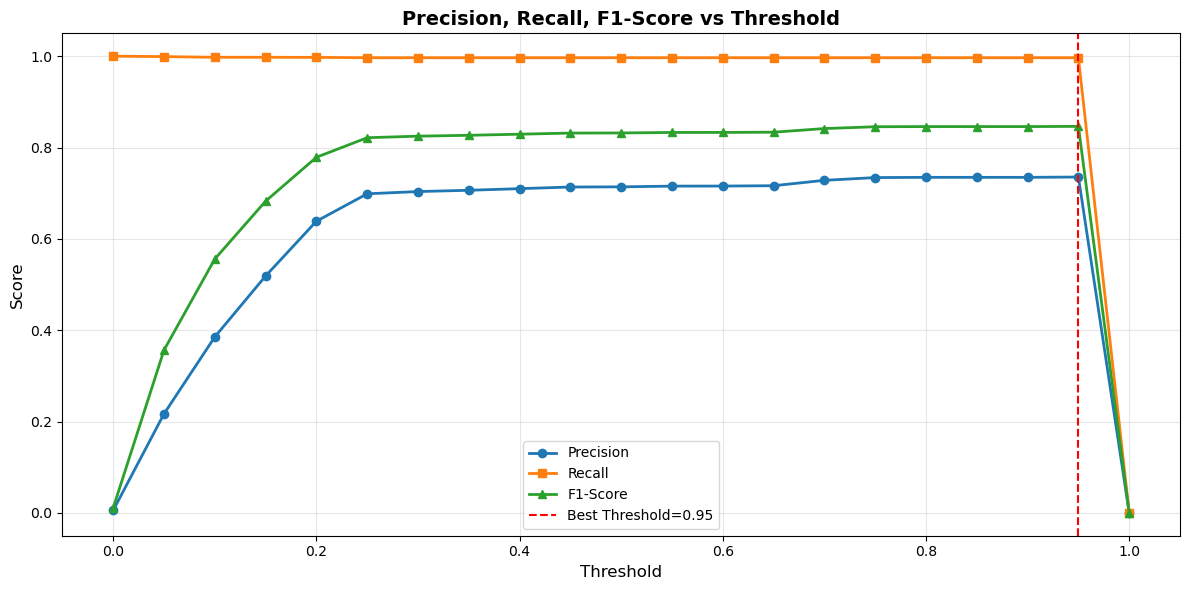

In [11]:
thresholds = np.arange(0.0, 1.01, 0.05)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    if y_pred_t.sum() == 0:
        precisions.append(0)
        recalls.append(0)
        f1s.append(0)
    else:
        precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_t, zero_division=0))
        f1s.append(f1_score(y_test, y_pred_t, zero_division=0))

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', marker='s', linewidth=2)
plt.plot(thresholds, f1s, label='F1-Score', marker='^', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold={best_threshold:.2f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, F1-Score vs Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Confusion Matrix với ngưỡng 0.5

In [12]:
#gán lại giá trị best_threshold cho các ô sau sử dụng
best_threshold = 0.5

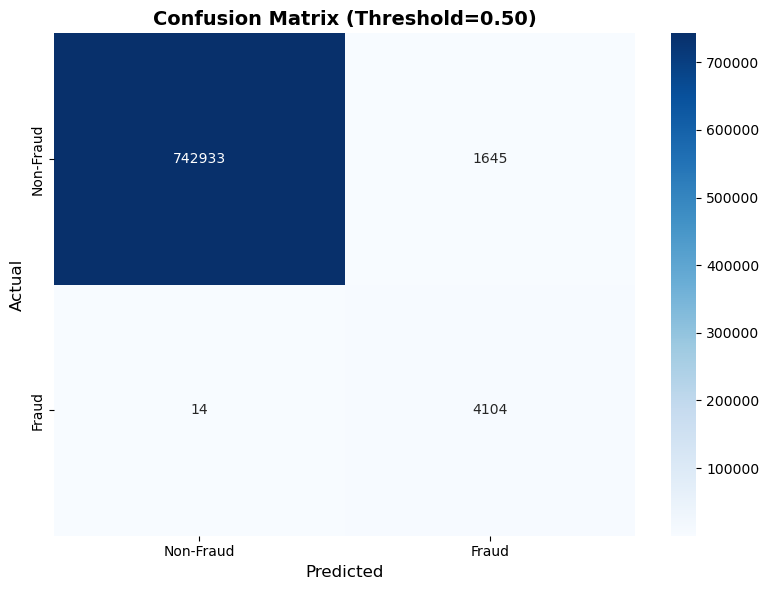


Classification Report với threshold=0.50:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    744578
           1       0.71      1.00      0.83      4118

    accuracy                           1.00    748696
   macro avg       0.86      1.00      0.92    748696
weighted avg       1.00      1.00      1.00    748696



In [13]:
y_pred_best = (y_proba >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nClassification Report với threshold={best_threshold:.2f}:")
print("="*80)
print(classification_report(y_test, y_pred_best))

## 10. Feature Importance

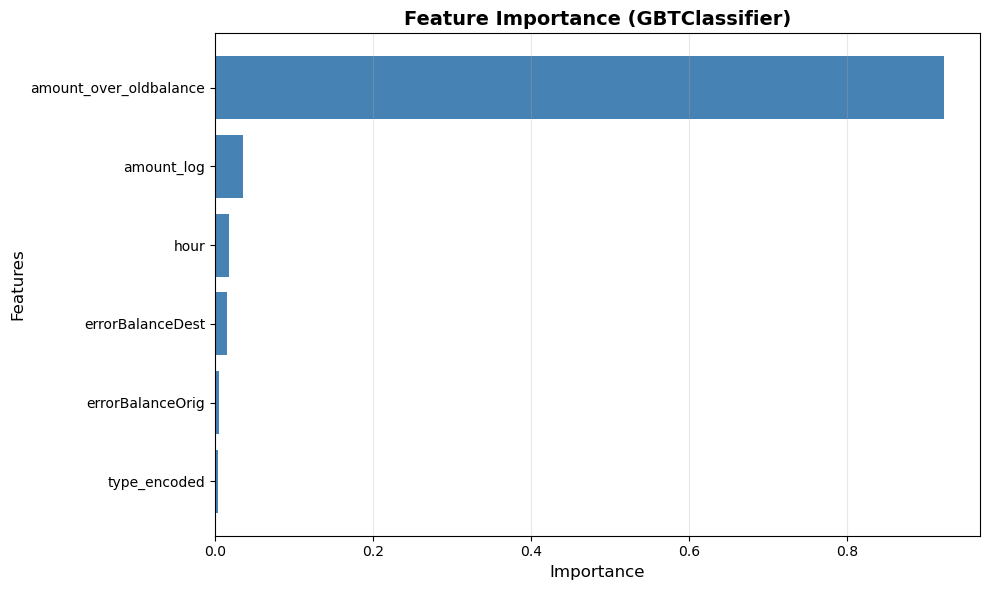


Feature Importance:
               Feature  Importance
amount_over_oldbalance    0.922478
            amount_log    0.035638
                  hour    0.017655
      errorBalanceDest    0.015188
      errorBalanceOrig    0.004683
          type_encoded    0.004357


In [14]:
# Lấy feature importance
import pandas as pd

feature_importance = model.featureImportances.toArray()

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=True)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance (GBTClassifier)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print("="*80)
print(importance_df.sort_values('Importance', ascending=False).to_string(index=False))

In [15]:
# Dừng Spark Session
spark.stop()
print("\n🛑 Đã dừng Spark Session")


🛑 Đã dừng Spark Session
